### SFI Lunch Homework

In [1]:
import mesa

# Data visualization tools.
import seaborn as sns

# Has multi-dimensional arrays and matrices. Has a large collection of
# mathematical functions to operate on these arrays.
import numpy as np

# Data manipulation and analysis.
import pandas as pd

/Users/palokbiswas/miniforge3/envs/justice-env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


class MoneyAgent(mesa.Agent):

    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        # Pass the parameters to the parent class.
        super().__init__(unique_id, model)

        # Create the agent's attribute and set the initial values.
        self.wealth = 1

        self.steps_not_given = 0

    def move(self):
        # Move the agent to a random location.
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        # Get the agent at the new position.
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1
            self.steps_not_given = 0
        else:
            self.steps_not_given += 1

            # if other_agent == self:
            #     print("Agent {} gave money to itself.".format(self.unique_id))

    def step(self):
        # Move the agent.
        self.move()

        # Give money to another agent.
        if self.wealth > 0:
            self.give_money()
        else:
            self.steps_not_given += 1

class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        super().__init__()
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        # Create scheduler and assign it to the model
        self.schedule = mesa.time.RandomActivation(self)
        self.running = True

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            # Add the agent to the scheduler
            self.schedule.add(a)

            # Add the agent to the grid
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
        
        self.datacollector = mesa.datacollection.DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth", "Steps_not_given": "steps_not_given"}
        )

    def step(self):
        """Advance the model by one step."""

        # The model's step will go here for now this will call the step method of each agent and print the agent's unique_id
        self.datacollector.collect(self)
        self.schedule.step()



In [3]:
#create a model with 100 agents on a 10x10 grid, and run it for 20 steps.

model = MoneyModel(100, 10, 10)
for i in range(100):
    model.step()




Agent 78 gave money to itself.
Agent 71 gave money to itself.
Agent 60 gave money to itself.
Agent 80 gave money to itself.
Agent 82 gave money to itself.
Agent 66 gave money to itself.
Agent 31 gave money to itself.
Agent 39 gave money to itself.
Agent 14 gave money to itself.
Agent 64 gave money to itself.
Agent 51 gave money to itself.
Agent 26 gave money to itself.
Agent 22 gave money to itself.
Agent 44 gave money to itself.
Agent 97 gave money to itself.
Agent 86 gave money to itself.
Agent 30 gave money to itself.
Agent 9 gave money to itself.
Agent 7 gave money to itself.
Agent 47 gave money to itself.
Agent 32 gave money to itself.
Agent 53 gave money to itself.
Agent 52 gave money to itself.
Agent 88 gave money to itself.
Agent 98 gave money to itself.
Agent 4 gave money to itself.
Agent 78 gave money to itself.
Agent 71 gave money to itself.
Agent 22 gave money to itself.
Agent 93 gave money to itself.
Agent 88 gave money to itself.
Agent 8 gave money to itself.
Agent 84 gav

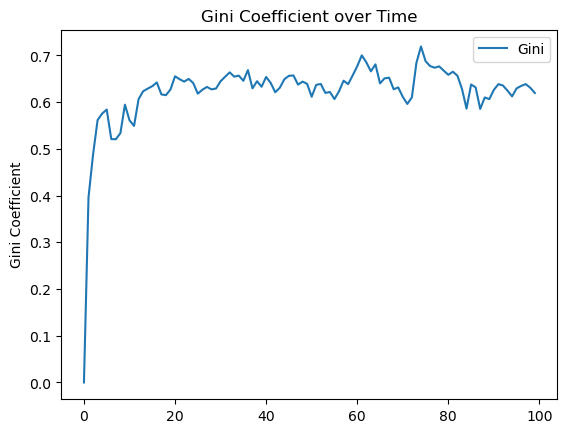

In [4]:
gini = model.datacollector.get_model_vars_dataframe()
# Plot the Gini coefficient over time
g = sns.lineplot(data=gini)
g.set(title="Gini Coefficient over Time", ylabel="Gini Coefficient");

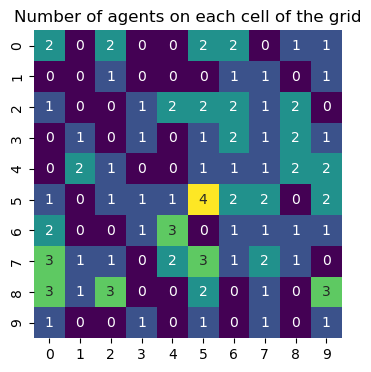

In [5]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x, y) in model.grid.coord_iter():
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
# Plot using seaborn, with a size of 5x5
g = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(4, 4)
g.set(title="Number of agents on each cell of the grid");

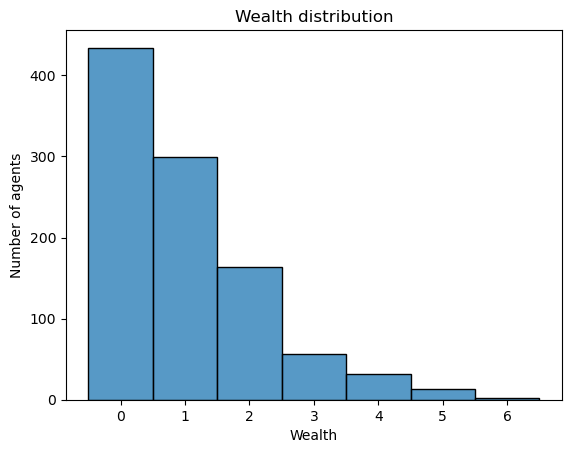

In [6]:
all_wealth = []
# This runs the model 100 times, each model executing 10 steps.
for j in range(100):
    # Run the model
    model = MoneyModel(10)
    for i in range(10):
        model.step()

    # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)

# Use seaborn
g = sns.histplot(all_wealth, discrete=True)
g.set(title="Wealth distribution", xlabel="Wealth", ylabel="Number of agents");

In [3]:
# Batch run

params = {"width": 10, "height": 10, "N": range(5, 100, 5)}

results = mesa.batch_run(
    MoneyModel,
    parameters=params,
    iterations=7,
    max_steps=100,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

  0%|          | 0/133 [00:00<?, ?it/s]